# Prediction of cross-flow strain along a riser in uniform current by using recurrent neural networks

### Introduction
This notebook presents a method to predict the strain in a riser in each time step by using a recurrent neural network (RNN). The data used are from the NDP high mode VIV tests. In the test, the acceleration of the riser was measured at 8 locations in cross-flow and in-line direction. The riser strain was measured at 24 locations for cross-flow and 44 locations for in-line. The idea of this model is to use the acceleration measurements and the displacements (derived from accelerations) to predict a normalized cross-flow strain at 24 locations. The idea is to reconstruct the structural responses from VIV and to locate which locations will experience largest strains based given fewer measurements. The prediction is made for each time step and a RNN is applied since measurements close in time are assumed to be correlated.

In [ ]:
import scipy.io
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, TimeDistributed, Dropout, MaxPooling1D, MaxPooling2D, Conv1D, Conv2D, Input, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
import itertools
from matplotlib import animation
%matplotlib inline

### Loading data

In [ ]:
text_df = pd.read_csv("TD_CONDITIONSET_uniform_3D.txt", delimiter = "\t", header=None)
text = text_df.values

### Preparation of data

First the time vector is generated. The experiments were done with a sampling frequency of 1200 Hz. The initial part and the last part of the data is discarded as it is loaded in. 

The location of the sensors in meters are also included.

An input tensor X, and output vector Y is made for each test cases. Accelerations and displacements are non-dimensionalized

X and Y are normalized.

Data are divided into mini-batches, where the time in each batch is conserved.

Each batch is randomly put in either train, test or validation set.

The time is removed from the input.

In [ ]:
list_inputs = []
list_outputs = []
n_tests = 1

# Choosing number of sensors
n_strain_sensors = 6
n_acc_sensors = 2

for i in range(0,n_tests):
    file = os.path.join("Data", f"test{int(text[i,0])}.mat")
    mat = scipy.io.loadmat(file)

    chan_names = mat['chan_names']
    chan_names = [chan_names[i].replace(" ","") for i in range(len(chan_names))]
    data = mat['data']
    
    df = pd.DataFrame(data)
    df = df.set_axis(chan_names, axis=0).transpose()
    
    D = 0.027 # Riser diameter
    U =  text[i,1]
    C = U**2/D
    
    # Time parameters
    t1 = text[i,10] # Start time
    t2 = text[i,11] # End time
    Fs = 1200 # Sampling freq
    dt = 1/Fs # Time step
    tst = int(t1*Fs) # Index for start
    ted = int(t2*Fs) # Index for end

    # Making a time vector
    nm = data.shape[1]
    time = np.arange(0,nm-1)*dt
    time = time[tst:ted].reshape(1,-1)

    # Defining feature vectors and cropping them from initial/end effects
    strain_CF = data[46:70,tst:ted]
    strain_CF_names = chan_names[46:70]
    strain_IL = data[6:46,tst:ted]
    strain_IL_names = chan_names[6:46]
    pos_IL = data[98:106,tst:ted] / D
    pos_CF = data[106:114,tst:ted] / D
    pos_CF_names = chan_names[106:114]
    acc_IL = data[70:78,tst:ted] / C
    acc_IL_names = chan_names[70:78]
    acc_CF = data[78:86,tst:ted] / C
    acc_CF_names = chan_names[78:86]
    mean_force = data[95:97,tst:ted].mean(axis=0)
    u = np.ones(mean_force.shape)*U

    # Strain sensor positions
    str_il = np.array([1.143,2.555,3.084,3.224,4.155,5.759,6.030,7.664,8.216,8.609,8.889,9.703,10.285,13.676,13.772,
                         15.393,16.452,16.547,16.891,19.997,20.193,21.393,21.603,22.460,23.165,25.153,25.442,26.254,27.532,
                         28.698,28.863,29.365,31.191,31.415,32.796,33.005,35.549,36.559,36.824,37.322])
    str_sensor_cf = np.array([2,3,4,5,7,10,11,13,14,17,19,20,21,22,24,25,26,28,31,32,33,36,38,40])-1
    str_cf = str_il[str_sensor_cf]

    # Accelerometer positions
    acc_loc = np.array([4.155,8.609,13.676,16.891,21.393,25.153,28.863,33.005])
    
    max_strain = strain_CF.argmax(axis=0)
    
    # Chose random strain sensors
    N_sensor = np.arange(0,strain_CF.shape[0])
    #known_CF = np.random.choice(N_sensor,n_strain_sensors,replace=False)
    #unknown_CF = n_CF_sensors[np.isin(n_CF_sensors,known_CF,invert=True)]
    #known_CF.sort()
    known_strain_idx = np.array([0,6,10,16,20,23])
    unknown_strain_idx = N_sensor[np.isin(N_sensor,known_strain_idx,invert=True)]
    
    # Chose random accelerometer sensors
    #N_sensor = np.arange(0,acc_CF.shape[0])
    #known_acc = np.random.choice(N_sensor,n_acc_sensors,replace=False)
    known_acc_idx = np.array([1,4,7])
    known_acc = acc_CF[known_acc_idx,:]
    
    
    # Divide sensor data
    known_strain_CF = strain_CF[known_strain_idx,:]
    unknown_strain_CF = strain_CF[unknown_strain_idx,:]
    
    #Xi = np.vstack((time,pos_IL,pos_CF,acc_IL,acc_CF)).transpose()
    Xi = np.vstack((time,known_strain_CF,known_acc)).transpose()
    Yi = np.vstack(unknown_strain_CF).transpose()
    
    scaler = StandardScaler()
    scaler.fit(Xi)
    Xi = scaler.transform(Xi)
    scaler = StandardScaler()
    scaler.fit(Yi)
    Yi = scaler.transform(Yi)
    
    b_size = 1000
    n_batches = Xi.shape[0]//b_size

    if not n_batches == 0:
        n_batches = Xi.shape[0] // b_size
        Xi = Xi[:n_batches*b_size,:]
        Yi = Yi[:n_batches*b_size,:]

    n_features = Xi.shape[1]
    n_outputs = Yi.shape[1]

    Xi = Xi.reshape(n_batches,b_size,n_features)
    Yi = Yi.reshape(n_batches,b_size,n_outputs)
    
    list_inputs.append(Xi)
    list_outputs.append(Yi)

X = np.concatenate(([list_inputs[i] for i in range(0,n_tests)]),axis=0)
Y = np.concatenate(([list_outputs[i] for i in range(0,n_tests)]),axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42,shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=1, shuffle=False)

t_train = X_train[:,:,0]
t_val = X_val[:,:,0]
t_test = X_test[:,:,0]
X_train = X_train[:,:,1:]
X_test = X_test[:,:,1:]
X_val = X_val[:,:,1:]

#n_outputs = Y.max()+1
n_features = n_features-1

print(f'X-train: (batches, time steps in batch, features) = {X_train.shape}')
print(f'Y-train: (batches, time steps in batch, output)   = {y_train.shape}')
print(f'X-valid: (batches, time steps in batch, features) = {X_val.shape}')
print(f'Y-valid: (batches, time steps in batch, output)   = {y_val.shape}')
print(f'X-test : (batches, time steps in batch, features) = {X_test.shape}')
print(f'Y-test : (batches, time steps in batch, output)   = {y_test.shape}')

### Visualizing sensor locations

In [ ]:
plt.figure(figsize=(16,3))
plt.scatter(str_cf[known_strain_idx],np.zeros(known_strain_idx.shape)+0.005,marker='s',c='k',label="Known strain sensors")
plt.scatter(acc_loc[known_acc_idx],np.zeros(known_acc_idx.shape),marker='s',c='b',label="Known accelerometer sensors")
plt.scatter(str_cf[unknown_strain_idx],np.zeros(unknown_strain_idx.shape)-0.005,marker='x',c='r',label="Unknown strain sensors")
plt.legend()
plt.xlabel("Length [m]")
plt.yticks(ticks=[])
plt.ylim([-0.04,0.04])
plt.show()

### Correlation plot

In [ ]:
input_output_data = np.vstack((acc_CF,pos_CF,strain_CF)).transpose()
input_output_names = np.hstack((acc_CF_names,pos_CF_names,strain_CF_names))
d = pd.DataFrame(data=input_output_data,columns=input_output_names)
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

### Building RNN model

LSTM model with tanh activation.

Output layer with linear activation.

Mean squared error loss.


Image: https://colah.github.io/posts/2015-08-Understanding-LSTMs/

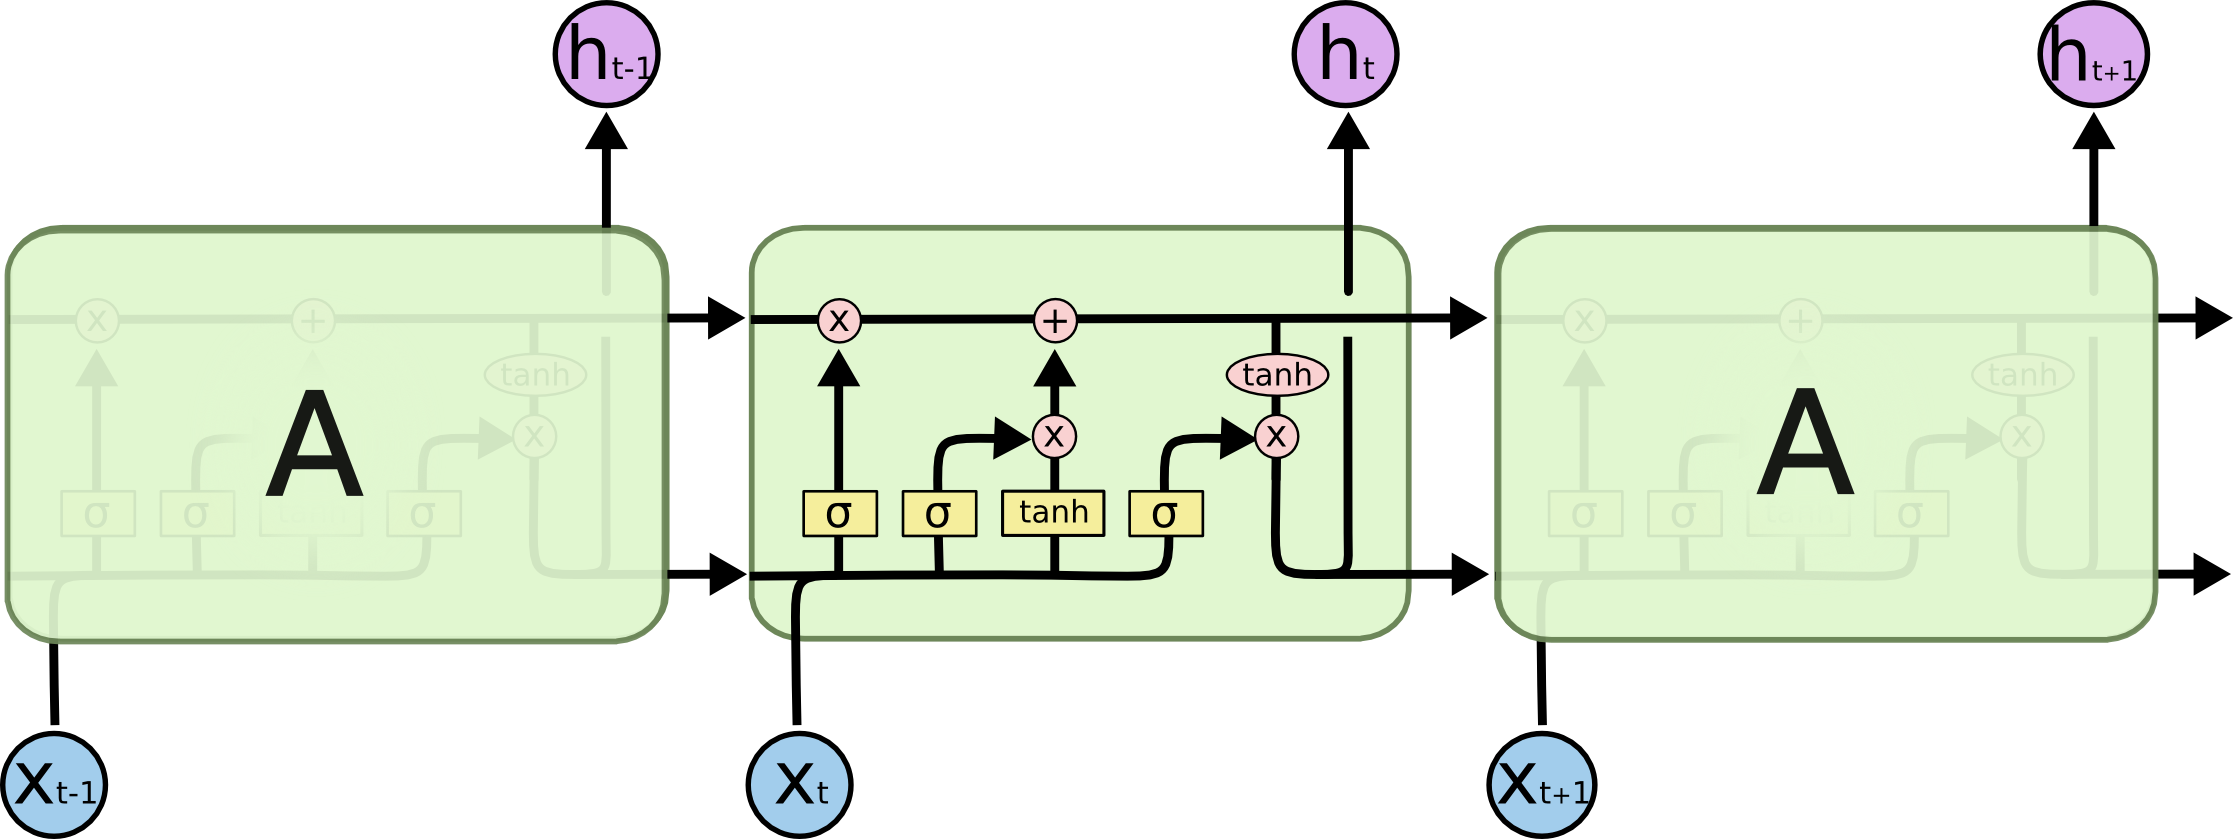

In [ ]:
# LSTM Regression
model = Sequential(name='LSTM')
model.add(LSTM(
    units=200,
    batch_input_shape=(None,X.shape[1],n_features),
    return_sequences=True,
    dropout=0.2,
    recurrent_dropout=0.2,
    activation='tanh'))
model.add(Dense(40,activation='tanh'))
#model.add(Dropout(0.2))
model.add(Dense(n_outputs, activation='linear'))

model.summary()
model.compile(optimizer="Adam", loss="mean_squared_error", metrics=['mean_squared_error'])

### Training model

Using an early stopping criteria.

Can continue training for a max of 100 epochs.

Validation data is used at each epoch.

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.fit(X_train,y_train,epochs=100,callbacks=callback,validation_data=(X_val, y_val),verbose=True)

In [ ]:
test_loss = model.evaluate(X_test,  y_test, verbose=2)

In [ ]:
#model.save('Models/LSTM')

### Prediction

In [ ]:
y_pred = model.predict(X_test)
y_pred_amax = y_pred.argmax(axis=2)
y_test_amax = y_test.argmax(axis=2)

In [ ]:
n = 6 #sensor number
b = 9 # batch number

plt.figure(figsize=(16,10))
plt.plot(t_test[b,:],y_test[b,:,n],label="Test set")
plt.plot(t_test[b,:],y_pred[b,:,n],label="Prediction")
plt.legend()
plt.xlim()
plt.xlabel("Time [s]")
plt.ylabel("Strain [-]")
plt.title(f"Strain prediction at z = {str_cf[unknown_strain_idx[n]]} m")
plt.grid()
plt.show()

### Test strain and predicted strain for 1 batch

In [ ]:
strain_CF_true = np.zeros((y_test.shape[0],y_test.shape[1],strain_CF.shape[0]))
strain_CF_true[:,:,unknown_strain_idx] = y_test
strain_CF_true[:,:,known_strain_idx] = X_test[:,:,0:n_strain_sensors]

strain_CF_pred = np.zeros((y_pred.shape[0],y_pred.shape[1],strain_CF.shape[0]))
strain_CF_pred[:,:,unknown_strain_idx] = y_pred
#strain_CF_pred[:,:,known_CF] = X_test[:,:,0:n_sensors]

In [ ]:
n = 0
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(3,figsize=(12,12))
plt1 = ax[0].imshow(strain_CF_true[n,:,:].T,cmap='RdBu',interpolation='nearest', aspect='auto')
ax[0].set_ylabel('Sensor number [-]')
ax[0].set_xlabel('Time step [-]')
ax[0].set_title('True')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(plt1, cax=cax, orientation='vertical')
plt2 = ax[1].imshow(strain_CF_pred[n,:,:].T,cmap='RdBu',interpolation='nearest', aspect='auto')
ax[1].set_ylabel('Sensor number [-]')
ax[1].set_xlabel('Time step [-]')
ax[1].set_title('Prediction')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(plt2, cax=cax, orientation='vertical')
plt3 = ax[2].imshow(strain_CF_true[n,:,:].T-strain_CF_pred[n,:,:].T,cmap='RdBu',interpolation='nearest', aspect='auto')
ax[2].set_ylabel('Sensor number [-]')
ax[2].set_xlabel('Time step [-]')
ax[2].set_title('True - Prediction')
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(plt3, cax=cax, orientation='vertical')
fig.tight_layout(pad=3.0)
plt.show()

### Strain distribution for 10 time steps

In [ ]:
n = 9
starttimestep = 100
its = np.arange(starttimestep,starttimestep+10)
plt.figure(figsize=(16,6))
for i,it in enumerate(its):
    line2,=plt.plot(str_cf,strain_CF_true[n,it,:],'k',alpha=0.1*i)
    #line1,=plt.plot(str_cf,strain_CF_pred[n,it,:],'ro',alpha=0.1*i)
    line1,=plt.plot(str_cf[unknown_strain_idx],y_pred[n,it,:],'ro',alpha=0.1*i)
line1.set_label('Pred')
line2.set_label('True')  
plt.grid()
plt.legend()
plt.xlabel('Length along riser [m]')
plt.ylabel('Normalized strain')
plt.title('Strain prediction over 10 time steps')
plt.show()

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(str_cf[unknown_strain_idx],np.std(y_test.reshape(-1,18),axis=0),'b-o',label="True")
plt.plot(str_cf[unknown_strain_idx],np.std(y_pred.reshape(-1,18),axis=0),'r-o',label="Prediction")
plt.grid()
plt.ylabel('std(Strain) [-]')
plt.legend()
plt.show()

### Animation

In [ ]:
import matplotlib
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
matplotlib.use("Agg")
%matplotlib qt

n = 2
fig, ax = plt.subplots()
ax.set_xlabel('Length along riser [m]')
ax.set_ylabel('Strain')
ax.set_xlim([0,40])
ax.set_ylim([-5,5])
line1, = ax.plot(str_cf,strain_CF_true[n,0,:],'k-',label='True')
#line2, = ax.plot(str_cf,strain_CF_pred[n,0,:],'r-',label='Prediction')
line2, = ax.plot(str_cf[unknown_strain_idx],y_pred[n,0,:],'r-o',label='Prediction')

def animate(i):
    x_data = str_cf
    line1.set_xdata(x_data)
    line1.set_ydata(strain_CF_true[n,i,:])
    #line2.set_xdata(x_data)
    #line2.set_ydata(strain_CF_pred[n,i,:])
    line2.set_xdata(x_data[unknown_strain_idx])
    line2.set_ydata(y_pred[n,i,:])
    return line1,line2,

ani = FuncAnimation(fig, func=animate, frames=np.arange(0,b_size), interval=10)
plt.legend()
plt.grid()
plt.show()

In [ ]:
plt.imshow(np.cov(strain_CF))

### Gaussian process

In [ ]:
%matplotlib inline
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Exponentiation, DotProduct, WhiteKernel, RBF, Matern, ConstantKernel as C

n = 10
starttimestep = 100

sample_size = 2000
x_sample = np.atleast_2d(np.linspace(0, 38, sample_size)).T

N = 1

X_tr = np.tile(str_cf,N).reshape(-1,1)
y_tr = np.zeros((strain_CF.shape[0],1))
y_tr[known_strain_idx,0] = X_test[n,starttimestep,0:n_strain_sensors]
y_tr[unknown_strain_idx,0] = y_pred[n,starttimestep,:]

#X_tr = np.tile(str_cf[known_CF],N).reshape(-1,1)
#y_tr = X_train[2,0:N,:].reshape(-1,1)
X_te = np.tile(str_cf[unknown_strain_idx],N).reshape(-1,1)
y_te = y_test[n,starttimestep,:].reshape(-1,1)

kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9,alpha=0)
gpr.fit(X_tr, y_tr)
params = gpr.kernel_.get_params()

y_sample, sigma = gpr.predict(x_sample,return_std=True)
y_p, std = gpr.predict(X_te,return_std=True)

plt.figure(figsize = (12,8))
plt.fill(np.concatenate([x_sample, x_sample[::-1]]),
         np.concatenate([y_sample.ravel() - 1.96*sigma,
                        (y_sample.ravel() + 1.96*sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.plot(x_sample, y_sample, 'k-')
plt.plot(X_tr, y_tr, 'b.', markersize=10, label='Sensors')
plt.plot(X_te, y_te, 'ko', label='test observations')
plt.plot(X_te, y_p, 'ro', label='predictions')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc='upper right')
plt.show()